# 线性回归模型的多层次实现

In [1]:
import tensorflow as tf

# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    
    tf.print("=========="*8+timestring)

# 准备数据

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf


# 样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2], minval=-10, maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


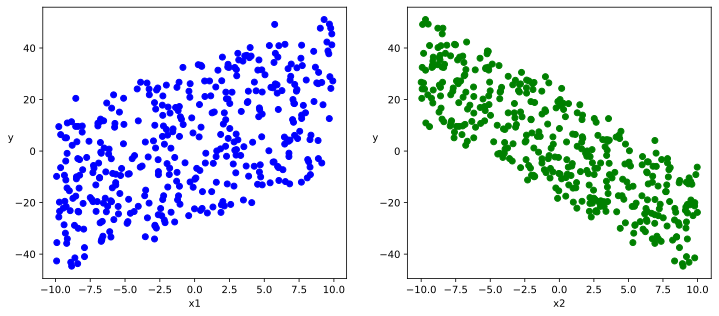

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [5]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 4.74144     7.889681  ]
 [-6.6635633   7.1749306 ]
 [ 0.34623146 -5.090759  ]
 [-2.6471019  -7.6784515 ]
 [ 5.9545593   7.0171757 ]
 [ 8.550659   -5.142629  ]
 [-7.0783806   3.3749886 ]
 [-1.767004   -6.1898327 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-10.035969]
 [-34.120247]
 [ 18.05651 ]
 [ 24.490097]
 [ -5.932144]
 [ 38.71741 ]
 [-23.40358 ]
 [ 14.747521]], shape=(8, 1), dtype=float32)


# 低阶 API

## 定义模型

In [6]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# 定义模型
class LinearRegression:     
    #正向传播
    def __call__(self,x): 
        return x@w + b

    # 损失函数
    def loss_func(self, y_true, y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

## 训练模型

In [8]:
# 使用动态图调试
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [9]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=348.93536>

In [11]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================18:29:40
epoch = 50 loss =  2.82445335
w = [[2.02097297]
 [-3.0003252]]
b = [[2.99476624]]
================================================================================18:29:44
epoch = 100 loss =  2.67956805
w = [[2.03775692]
 [-3.00236607]]
b = [[2.99380207]]
================================================================================18:29:48
epoch = 150 loss =  2.56519294
w = [[2.01518416]
 [-2.99936295]]
b = [[2.99314165]]
================================================================================18:29:52
epoch = 200 loss =  2.97016692
w = [[2.03759217]
 [-3.00029922]]
b = [[2.99328423]]


## 结果展示

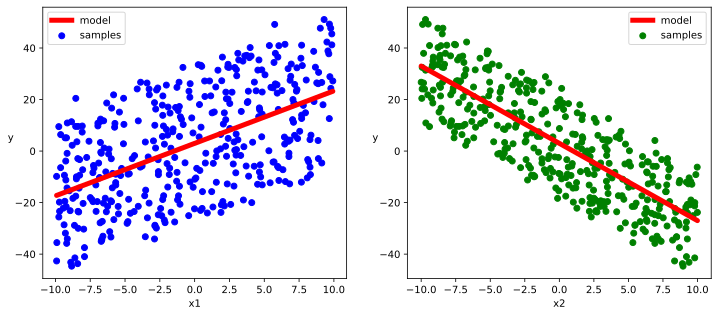

In [12]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


# 中阶 API

In [13]:
# 构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

## 定义模型



In [16]:
from tensorflow.keras import layers,losses,metrics,optimizers

model = layers.Dense(units = 1) 
model.build(input_shape = (2,)) # 用 build 方法创建 variables
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

## 训练模型

In [17]:
# 使用autograph机制转换成静态图加速
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

# 测试 train_step 效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model,features,labels)
            
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])
  
train_model(model,epochs = 200)

================================================================================18:35:05
epoch = 50 loss =  5.487885
w = [[2.0212338]
 [-2.99273038]]
b = [2.94328976]
================================================================================18:35:07
epoch = 100 loss =  6.56964
w = [[2.03173566]
 [-2.98185158]]
b = [2.99711871]
================================================================================18:35:08
epoch = 150 loss =  4.19853354
w = [[2.04785562]
 [-2.9908154]]
b = [2.99681926]
================================================================================18:35:10
epoch = 200 loss =  4.84950733
w = [[2.03336811]
 [-2.99567819]]
b = [2.99853277]


## 结果展示

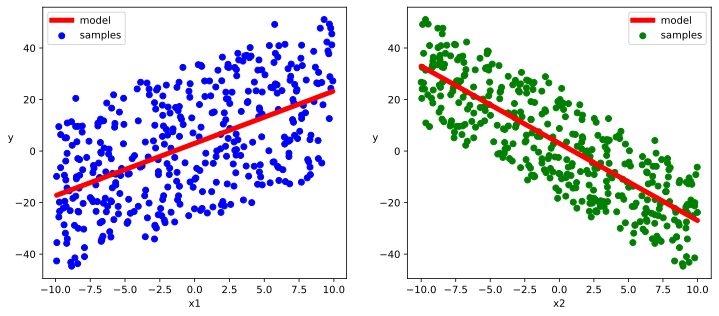

In [18]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

# 高阶 API

TensorFlow 的高阶 API 主要为 tf.keras.models 提供的模型的类接口。使用 Keras 接口有以下3种方式构建模型：使用 Sequential 按层顺序构建模型，使用函数式 API 构建任意结构模型，继承 Model 基类构建自定义模型。

此处分别演示使用Sequential按层顺序构建模型以及继承Model基类构建自定义模型。

## 定义模型

In [20]:
from tensorflow.keras import models,layers,losses,metrics,optimizers

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(1,input_shape =(2,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [21]:
### 使用fit方法进行训练

model.compile(optimizer="adam",loss="mse",metrics=["mae"])
model.fit(X,Y,batch_size = 10,epochs = 200)  

tf.print("w = ",model.layers[0].kernel)
tf.print("b = ",model.layers[0].bias)

Epoch 1/200
40/40 [==============================] - 0s 868us/step - loss: 680.4720 - mae: 21.5911
Epoch 2/200
40/40 [==============================] - 0s 862us/step - loss: 664.8797 - mae: 21.3402
Epoch 3/200
40/40 [==============================] - 0s 910us/step - loss: 649.3632 - mae: 21.0929
Epoch 4/200
40/40 [==============================] - 0s 913us/step - loss: 634.0779 - mae: 20.8446
Epoch 5/200
40/40 [==============================] - 0s 963us/step - loss: 619.3495 - mae: 20.5977
Epoch 6/200
40/40 [==============================] - 0s 905us/step - loss: 604.6261 - mae: 20.3525
Epoch 7/200
40/40 [==============================] - 0s 903us/step - loss: 590.1236 - mae: 20.1073
Epoch 8/200
40/40 [==============================] - 0s 882us/step - loss: 576.1805 - mae: 19.8646
Epoch 9/200
40/40 [==============================] - 0s 833us/step - loss: 562.1744 - mae: 19.6229
Epoch 10/200
40/40 [==============================] - 0s 858us/step - loss: 548.7174 - mae: 19.3842
Epoch 11/

## 结果展示

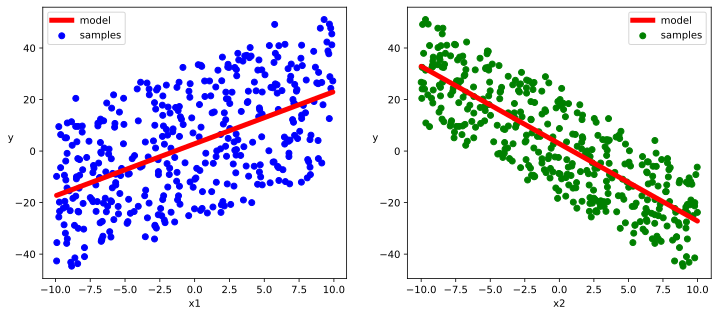

In [22]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()